<h1> DCGAN
<h2> Sonstige Prüfungsleistung im Modul Angewandte Programmierung 
<h3> Thema: Anime GAN  
<h4> Autorin: Kim-Kristin Mähl (582494)

https://arxiv.org/pdf/1511.06434.pdf

<h1> 1 Download: Opendataset

In [5]:
!pip install opendatasets ##Opendataset installieren - ist eine Python-Bibliothek zum Herunterladen von Datensätzen aus Online-Quellen wie Kaggle und Google Drive.

<h1> 2 Importieren von Paketen

In [6]:
#Import Pakete
import opendatasets as od # Dient zum Laden des Dataset aus opensource-Quellen (z.B. Kaggle)
import os                 # Dient zum lokalen Speichern des Datasets
import numpy as np
import torch as t
import torchvision
from torchvision import datasets
import torch.utils.data as DataLoader
import torchvision.datasets as ImageFolder
import torchvision.transforms as transforms #Transformieren von Bildern
import matplotlib.pyplot as plt #plotten von Grafen/ Bildern
from torchvision.utils import make_grid
import torch.nn as nn # Neuronales Netz
import torch.optim as optim #Optimierungs-Algorithmen
from torchvision.utils import save_image #Speichern von Bildern
import torch.nn.functional as F #Loss


<h1> 3 Definieren/ Initialisieren von Parametern

In [7]:
IMAGE_SIZE = 64 # Größe der Bilder 
BATCH_SIZE = 128  #Anzahl der Batches
WORKERS = 2 # Anzahl der Kerne beim Arbeiten auf der GPU
NORM = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Normalisierung mit 0.5 Mittelwert und Standardabweichung für alle drei Channels der Bilder
NUM_EPOCH = 20 #Anzahl der Epochen
LR= 0.001 #Learningrate
LATENT_SIZE = 100 # Radom Input für den Generator

<h1>4 Dataset
"Anime-Dataset"


<h2> 4.1 Download des Datasets von Kaggle 

In [8]:
#https://jovian.ai/ahmadyahya11/pytorch-gans-anime
#Ordner für den Download anlegen
data_dir = '../data/'
os.makedirs(data_dir,exist_ok=True) #Anlegen eines Ordners für Bilder

# Erklärung zum Umgang mit Opendata und Kaggle - https://pypi.org/project/opendatasets/
# Datensatz:Anime-Faces werden von Kaggle geladen
# Hierfür wird der User-API-KEY benötigt
# Anlegen eines Ordners für Bilder
data_dir = '../data/'
os.makedirs(data_dir, exist_ok=True)

# Erklärung zum Umgang mit Opendata und Kaggle - https://pypi.org/project/opendatasets/
# Datensatz:Anime-Faces werden von Kaggle geladen
# Hierfür wird der User-API-KEY benötigt
# APIKEY {"username":"XXXX","key":"XXXXX"}
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
# Images werden in './animefacedataset' gespeichert
od.download(dataset_url, data_dir)

# zeigt Ordner unter "../data/" an
print(os.listdir(data_dir))  

# gibt 10 Bezeichnungen von Bildern aus (Prüfung ob Bilder geladen worden)
print(os.listdir(data_dir+'animefacedataset/images')[:10])
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url, data_dir) # Images werden in './animefacedataset' gespeichert 

Skipping, found downloaded files in "../data/animefacedataset" (use force=True to force download)
['animefacedataset', '.gitkeep', 'outputs']
['4426_2003.jpg', '38921_2012.jpg', '55591_2016.jpg', '8777_2004.jpg', '56274_2017.jpg', '24208_2008.jpg', '13759_2006.jpg', '19302_2007.jpg', '14698_2006.jpg', '30569_2010.jpg']
Skipping, found downloaded files in "../data/animefacedataset" (use force=True to force download)


<h2> 4.2 Prüfen von Verzeichnisen und deren Inhalten (Images)

In [9]:
print(os.listdir(data_dir)) # zeigt Ordner an

['animefacedataset', '.gitkeep', 'outputs']


In [10]:
print(os.listdir(data_dir+'animefacedataset/images')[:10]) # gibt 10 Bezeichnungen von Bildern aus

['4426_2003.jpg', '38921_2012.jpg', '55591_2016.jpg', '8777_2004.jpg', '56274_2017.jpg', '24208_2008.jpg', '13759_2006.jpg', '19302_2007.jpg', '14698_2006.jpg', '30569_2010.jpg']


<h1> 5 Vorbereiten& Erstellen des Dataloaders

In [11]:
# Kurzerklärung - https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

# Transformer
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),        # Resize der Images auf 64 der kürzesten Seite; Andere Seite wird 
                                          # skaliert, um das Seitenverhältnis des Bildes beizubehalten.
    transforms.CenterCrop(IMAGE_SIZE),    # Zuschneiden auf die Mitte des Images, sodass ein quadratisches Bild mit 64 x 64 Pixeln entsteht
    transforms.ToTensor(),                # Umwandeln in einen Tensor (Bildern in numerische Werte umwandeln)
    transforms.Normalize(*NORM)])          # Normalisierung Mean & Standardabweichung von 0.5 für alle Channels 
                                                                      # (Anzahl: 3 für farbige Bilder)
                                                                      # Pixelwerte liegen damit zwischen (-1;1)  

# Dataset
"""
ImageFolder() : Befehl erwartet, dass nach Images nach labeln organisiert sind (root/label/picture.png)
"""
org_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)  

# Dataloader
"""
Dataloader(): ermöglicht zufällige Stichproben der Daten auszugeben;
Dient dazu, dass das Modell nicht mit dem gesamten Dataset umgehen muss > Training effizienter
"""
org_loader = t.utils.data.DataLoader(org_dataset,              # Dataset (Images)
                                        batch_size=BATCH_SIZE, # Es wird auf Batches trainiert, damit auf Basis eines Batch-Fehlers das NN angepasst wird
                                        shuffle=True, 
                                        num_workers=WORKERS)

<h1> 6 Abfrage des Devices (CPU o. GPU) und Laden des Tensors auf das jeweilige verfügbare Device

In [12]:
# Nutzen der GPU wenn vorhanden, ansonsten CPU
def get_default_device():
    if t.cuda.is_available():     # Wenn cuda verfügbar dann:
        return t.device('cuda')   # Nutze Device = Cuda (=GPU)
    else:                         # Ansonsten
        return t.device('cpu')    # Nutze Device = CPU
    

In [13]:
# Anzeigen welches Device verfügbar ist
device = get_default_device()
print(device)

cpu


In [14]:
# Hilfsklasse zum Verschieben des Dataloaders "org_loader" auf das jeweilige Device
class DeviceDataLoader():

        # Initialisierung
        def __init__(self, dataloader, device):
            self.dataloader = dataloader
            self.device = device

        # Anzahl der Images pro Batch
        def __len__(self):
            return len(self.dataloader)
        
        # Erstellt einen Batch an Tensoren nach dem Verschieben auf das Device
        def __iter__(self):
            for batch in self.dataloader:
                yield tuple(tensor.to(self.device) for tensor in batch)

In [15]:
# Dataloader auf dem verfügbaren Device
org_loader = DeviceDataLoader(org_loader, device)

<h1> 7 Plotten der orginalen Images aus dem Dataset

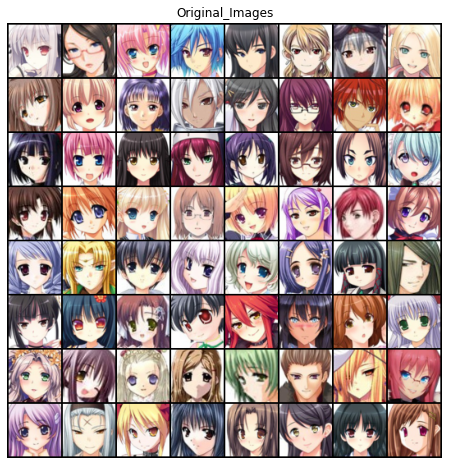

In [16]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

org_batch = next(iter(org_loader)) #Iterieren über Dataloader
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Original_Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(org_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))) #(1,2,0): Ausrichtung der Bilder

<h1> 8 Aufbau: Diskriminator und Generator

Orientierungshilfe:

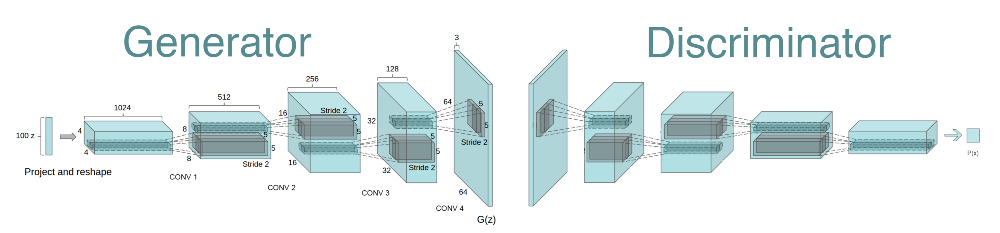


https://arxiv.org/pdf/1511.06434.pdf


<h2> 8.1 Generator

In [17]:
class Generator(t.nn.Module):
  """
  Generator 1 Input Layer; 3 Hidden Layer ; 1 Output Layer
  """
  def __init__(self):
        super(Generator,self).__init__()
        self.generator = nn.Sequential(
            # Output = (inputsize - 1)*stride - 2*padding + (kernelsite-1)+1
            nn.ConvTranspose2d(LATENT_SIZE,IMAGE_SIZE*8,4,1,0,bias=False),  # ConvTranspose2d hilft dabei aus einem kleinen
                                                                            # hilft einen größeren Tensor zu erstellen (Bezogen auf Channels)
            nn.BatchNorm2d(IMAGE_SIZE*8),
            nn.ReLU(inplace=True), #Relu lässt keine negativen werte zu

            nn.ConvTranspose2d(IMAGE_SIZE*8,IMAGE_SIZE*4,4,2,1,bias=False),
            nn.BatchNorm2d(IMAGE_SIZE*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(IMAGE_SIZE*4,IMAGE_SIZE*2,4,2,1,bias=False),
            nn.BatchNorm2d(IMAGE_SIZE*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(IMAGE_SIZE*2, IMAGE_SIZE,4,2,1,bias=False),
            nn.BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(IMAGE_SIZE,3,4,2,1,bias=False),            
            nn.Tanh() # (-1 und 1) ; Tanh wird häufig verwendet da eine begrenzte Aktivierung es dem Modell ermöglicht, 
                      # schneller zu lernen. (https://arxiv.org/pdf/1511.06434.pdf S. 3)
            
            # Output: 3 x 64 x 64     
        )
  
  # Feedforward 
  def forward(self,input):
     output =  self.generator(input)
     return output

In [18]:
#Erstellen des Generators
NN_Generator = Generator().to(device)
print(NN_Generator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

<h2> 8.2 Discriminator

In [19]:
class Discriminator (t.nn.Module):
  """
  Diskriminator 1 Input Layer; 3 Hidden Layer ; 1 Output Layer
  """
  def __init__(self):
        super(Discriminator,self).__init__()
        self.discriminator = nn.Sequential(
            # Output = ((inputsize) + 2*padding + (kernelsite-1)-1/stride) -1
            nn.Conv2d(3,IMAGE_SIZE,4,2,1, bias=False), #conv2d hilft dabei aus einem großem Tensor einen kleinen Tensor zu stellen
            nn.LeakyReLU(0.2,inplace=True), # Leaky RELU lässt negative Werte zu (nicht wie RELU); Neuronen werden somit nicht auf Null gesetzt
                                            # Hilft dem Generator, da dieser nur "Lernen" kann wenn er vom Diskriminator einen Gradienten erhält

            # state size. (IMAGE_SIZE) x 32 x 32
            nn.Conv2d(IMAGE_SIZE, IMAGE_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(IMAGE_SIZE * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (IMAGE_SIZE*2) x 16 x 16
            nn.Conv2d(IMAGE_SIZE * 2, IMAGE_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(IMAGE_SIZE * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(0.1),  #Dropout 

            # state size. (IMAGE_SIZE*4) x 8 x 8
            nn.Conv2d(IMAGE_SIZE * 4, IMAGE_SIZE * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(IMAGE_SIZE * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.1), # Dropout

            # state size. (IMAGE_SIZE*8) x 4 x 4
            nn.Conv2d(IMAGE_SIZE * 8, 1, 4, 1, 0, bias=False),

            #Sigmoid Aktivierungsfunktion
            nn.Sigmoid()) # (Werte zwischen 0 und 1); Sigmoid wird verwendet, um zu erkenen wie weit die generierten Bilder von den orginalen abweichen 
          
  # Feedforward
  def forward(self,input):
     output = self.discriminator(input)
     output = output.view(output.size(0), -1)
     return output

In [20]:
#Erstellen des Diskriminators

NN_Discriminator = Discriminator().to(device)
print(NN_Discriminator)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (

*Gewichtsinitialisierung von Generator und Diskriminator*

In [ ]:
# mean 0 and Standardabweichung 0.02
def w_initial(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        t.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        t.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        t.nn.init.constant_(m.bias, val=0)
        
NN_Generator = NN_Generator.apply(w_initial)
NN_Discriminator = NN_Discriminator.apply(w_initial)

*Hilfsfunktionen: Normalisierung und Grafische Darstellung*

In [21]:
# Hilfsfunktionen zur Normalisierng von Tensoren und grafischen Darstellung
def tensor_norm (img_tensors):
    # print (img_tensors)
    # print (img_tensors * NORM [1][0] + NORM [0][0])
    return img_tensors * NORM [1][0] + NORM [0][0] 

# Anzeigen der Bilder (Grafische Darstellung)    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    plt.title("Fake_Images")
    ax.imshow(make_grid(tensor_norm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0).cpu()) # detach() : erstellt eine neue "Ansicht", 
                                                                                             # sodass diese Operationen nicht mehr verfolgt werden, 
                                                                                             # d. h. der Gradient wird nicht berechnet und der Untergraph
                                                                                             # wird nicht aufgezeichnet > Speicher wird nicht verwendet

*Erstellen eines Noisy Tensors (Radomisiert)*

torch.Size([128, 3, 64, 64])


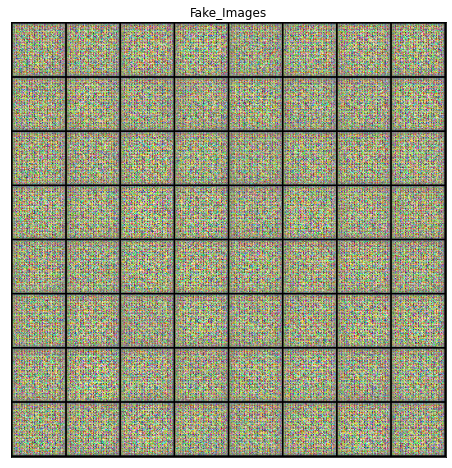

In [22]:
#Radom Tensor

# Generator --> Input: Random Tensor 
# Generator --> Output: Fake-Images (Batchsize, data_dim, Pixel, Pixel)
random_Tensor = t.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device= device)
fake_images = NN_Generator(random_Tensor)
print(fake_images.shape)

show_images(fake_images)

<h2> 8.3 Training - Generator

In [23]:
# Trainieren des Generators 

def gen_train(Gen_Opt): 

    #Gradienten = 0 
    Gen_Opt.zero_grad()

    #Generierung von Fake-Images
    fake_img = NN_Generator(random_Tensor)

    #Übergeben der Fakes-Images an den Diskriminator (Versuch den Diskriminator zu täuschen)
    pred = NN_Discriminator(fake_img)
    target = t.ones(BATCH_SIZE,1, device=device) #Torch.ones gibt einen tensor zurück welcher nur den Wert 1 enthält, und dem Shape Size = BATCH_SIZE
    loss = F.binary_cross_entropy(pred, target)  #loss_func(pred, target)

    # Backprop./ Update der Gewichte des Generators
    loss.backward()
    Gen_Opt.step()

    #print("Training Gen")
    return loss.item()

<h2> 8.4 Training - Diskriminator

In [24]:
# Trainieren des Diskriminators 

def disc_train(real_images, Dis_Opt): 

    #Gradienten = 0 
    Dis_Opt.zero_grad()

    """
    1 Trainieren des Diskriminators auf realen Bildern
    """

    # Reale Bilder werden an den Diskriminator übergeben
    pred_real = NN_Discriminator(real_images)
    #print(pred_real.size())
    
    #Kennzeichnen der realen Bilder mit 1  
    target_real = t.ones(real_images.size(0),1, device=device)
    #print(target_real.size())

    #Berechnung des Losses mit realen Bildern
    loss_real = F.binary_cross_entropy(pred_real, target_real) 
    real_score = t.mean(pred_real).item()
    
    """
    2 Erstellen von Fake_Bildern
    """
    #Generierung von Fakeimages
    fake_img = NN_Generator(random_Tensor).to(device)

    """
    3 Trainieren des Diskriminators auf den erstellten Fake_Bildern
    """
    # Fake Bilder werden an den Diskriminator übergeben
    pred_fake = NN_Discriminator(fake_img).to(device)

    #Kennzeichnen der Fake-Bilder mit 0
    target_fake = t.zeros(fake_img.size(0),1, device=device)

    # Loss Function - Fehler des Fake-Batch wird berechnet 
    loss_fake = F.binary_cross_entropy(pred_fake, target_fake)
    fake_score = t.mean(pred_fake).item()

    # Berechnung des Gesamt-Loss von realen und fake Images
    loss_sum = loss_real + loss_fake

    # Update der Gewichte des Diskriminators
    loss_sum.backward()
    Dis_Opt.step()

    #print("Training disc")
    return loss_sum.item(), real_score, fake_score


*Ordner anlegen für die vom Generator erstellten Images*

In [25]:
dir_gen_samples = '../outputs/dir_gen_samples'
os.makedirs('../outputs/dir_gen_samples',exist_ok=True)
#os.makedirs(dir_gen_samples,exist_ok=True)

*Funktion zum Speichern der vom Generator erstellten Images*

In [26]:
def saves_gen_samples(idx, random_Tensor):
    fake_img = NN_Generator(random_Tensor)              # Randomisierter Tensor wird an den Generator übergeben
    fake_img_name = "gen_img-{0:0=4d}.png".format(idx)  # Setzen von Bildbezeichnungen für die Fake_Images
    save_image(tensor_norm(fake_img), os.path.join(dir_gen_samples, fake_img_name), nrow=8)  # Tensor-Normalisierung; Speichern der Fake_Images im Ordner "Outputs/dir_gen_samples/"
    show_images(fake_img) # Plotten der Fake_Images
    print("Gespeichert")

Gespeichert


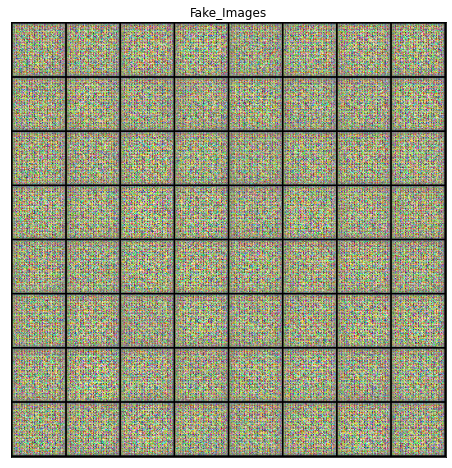

In [27]:
saves_gen_samples(0,random_Tensor)

<h1>9 Training

In [28]:
"""
Zentrale Trainings-Funktion
"""

def train(NN_Discriminator, NN_Generator, NUM_EPOCH, LR, start_idx=1):
    t.cuda.empty_cache() #leert den Cache, wenn auf der GPU gearbeitet wird
    
    NN_Discriminator.train()
    NN_Generator.train()

    # Listen für Übersicht des Fortschritts
    R_Score = []
    F_Score = []
    G_losses = []
    D_losses = []

    # Quelle: https://medium.com/@Biboswan98/optim-adam-vs-optim-sgd-lets-dive-in-8dbf1890fbdc
    # https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
    # t.optim.Adam(): Methode der stochastischen Optimierung; bringt im gegensatz zum SGD eine adaptive Lernrate mit
    # Momentum muss nicht wie beim SGD händisch definiert werden sonder Adam bringt es implizit in der Berechnung schon mit
    # Vorteile: wählt für jeden Parameter eine eigene LR. Sinnvoll bei Parametern die nur mit eine geringen frequenz
    # geupdatet werden/ die mit einer hohen Frequenz geupdatet werden (beschleunigt das Lernen in Fällen, 
    # in denen die geeigneten Lernraten zwischen den Parametern variieren)
    
    Gen_Opt = t.optim.Adam(NN_Generator.parameters(),lr=LR,betas=(0.6,0.999)) 
    Dis_Opt = t.optim.Adam(NN_Discriminator.parameters(),lr=LR,betas=(0.6,0.999))

    # Iteration über die Epochen
    for epoch in range(0, NUM_EPOCH):

        # Iteration über die Bilder 
        for i, (img_real, _) in enumerate(org_loader):

            # Trainieren des Diskrimniators
            d_loss, real_score, fake_score = disc_train(img_real, Dis_Opt)
            
            # Trainieren des Generators
            g_loss = gen_train(Gen_Opt) 
            
            #Count = i #Index/ Iterationen zählen
            #print("index:", i, "D_loss:", d_loss,"G_Loss:", g_loss)

        # Speichern des Gesamtlosses von D und G und der Real und Fake Scores
        D_losses.append(d_loss)
        G_losses.append(g_loss)
        R_Score.append(real_score)
        F_Score.append(fake_score)

        #Ausgabe EPOCH, Loss: G und D, Scores: Real und Fake
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, NUM_EPOCH, g_loss, d_loss, real_score, fake_score))

        # Speichern der generierten Samples/ Images
        saves_gen_samples(epoch+start_idx, random_Tensor)
    
    return G_losses, D_losses, R_Score, F_Score

In [29]:
# Aufruf der Trainingsfunktion (Diskriminator & Generator mit der LR & Anzahl der Epochen)
G_losses, D_losses, R_Score, F_Score =train(NN_Discriminator, NN_Generator , NUM_EPOCH, LR)

index: 0 D_loss: 1.4374277591705322 G_Loss: 7.70428466796875
index: 1 D_loss: 6.345625877380371 G_Loss: 14.87032699584961
index: 2 D_loss: 0.08510943502187729 G_Loss: 11.196099281311035
index: 3 D_loss: 6.388952732086182 G_Loss: 15.11184310913086
index: 4 D_loss: 0.6238202452659607 G_Loss: 13.834525108337402
index: 5 D_loss: 0.1051672175526619 G_Loss: 11.472949981689453
index: 6 D_loss: 0.06971631944179535 G_Loss: 5.9647979736328125
index: 7 D_loss: 10.902173042297363 G_Loss: 8.537657737731934
index: 8 D_loss: 0.2668682932853699 G_Loss: 9.163132667541504


KeyboardInterrupt: 

<h1> 10 Plotten des Loss von Diskriminator und Generator über die Epochen


In [ ]:
# Darstellung Loss 
EPOCH_COUNT_G= range(1,len(G_losses)+1) # Anzahl der Epochen vom Gen.
EPOCH_COUNT_D= range(1,len(D_losses)+1) # Anzahl der Epochen vom Dis.

plt.figure(figsize=(10,5))
plt.title("LOSS: Generator und Discriminator während dem Training")
plt.plot(EPOCH_COUNT_G, G_losses,"r-", label="Gen")
plt. plot(EPOCH_COUNT_D,D_losses,"b-", label="Dis")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.legend()
plt.show()